In [291]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from collections import Counter
from scipy.stats import entropy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import tree
from sklearn.linear_model import LogisticRegression


In [292]:
# functions to redo phase 1
def get_outliers(column: pd.Series):
    lower_quartile = column.quantile(0.25)
    upper_quartile = column.quantile(0.75)
    iqr = upper_quartile - lower_quartile
    return column[(column < lower_quartile - 1.5*iqr) | (column > upper_quartile + 1.5*iqr)]
def iterative_reformat(processes_ptr: pd.DataFrame, connections_ptr: pd.DataFrame) -> pd.DataFrame:
    connections_ptr['ts'] = pd.to_datetime(connections_ptr['ts'])
    processes_ptr['ts'] = pd.to_datetime(processes_ptr['ts'])
    merged = processes_ptr.merge(connections_ptr, on=['ts', 'imei', 'mwra'], how='inner')
    merged['mwra'] = merged['mwra'].astype('int64')
    merged.drop(columns=['ts', 'imei'], inplace=True)
    to_drop = []
    # handle null values and outliers
    for column in merged.columns:
        # if more than 5% are NaN values or more than 5% are outliers, we don't use that column
        column_outliers = get_outliers(merged[column])
        if ((merged[column].isna().sum()/merged.shape[0] > 0.05) or 
            (column_outliers.shape[0] / merged.shape[0] > 0.05)):
            to_drop.append(column)
            continue
        # if there are some null values, we replace the data that's neutral in respect to mwra
        if merged[column].isnull().any():
            # we get means of the distributions for rows with present and non-present malware related activity
            means_per_mwra = merged.groupby('mwra')[column].mean()
            # we average those means, meaning the manufactured value won't be likely to affect predicted mwra 
            imputed_value = means_per_mwra.mean()
            merged[column].fillna(imputed_value, inplace=True)
        #  if there are any outliers, we replace them with the edge values. If we clipped all outliers, we would clutter way too much data together, so we clip only the most extreme ones
        if column_outliers.shape[0]:
            iqr = stats.iqr(merged[column])
            lower_limit = merged[column].quantile(0.25)  - 2.5 * iqr
            upper_limit = merged[column].quantile(0.75)  + 2.5 * iqr
            merged[column] = merged[column].clip(lower=lower_limit, upper=upper_limit)
    return merged.drop(columns=to_drop)
# functions to redo phase 2

In [319]:
# getting the data from previous phases
connections, processes, = pd.read_csv('data/connections.csv', sep='\t', keep_default_na=False, na_values=''), pd.read_csv('data/processes.csv', sep='\t', keep_default_na=False, na_values=''),
combined_table = iterative_reformat(processes, connections)

# JANKA added
columns_to_divide = combined_table.columns.difference(['mwra'])
combined_table[columns_to_divide] = combined_table[columns_to_divide].apply(lambda x: x / 2)
combined_table = combined_table.astype('int64') 

X = combined_table.drop(columns=['mwra'])
y = combined_table['mwra']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Phase 3: Machine Learning

As we are dealing with continuous data, we will be using a different version of the ID3 algorithm opposed to the one shown in the lecture.  
Our implementation was inspired by the following implementation: https://www.geeksforgeeks.org/iterative-dichotomiser-3-id3-algorithm-from-scratch/

In [294]:
def calculate_entropy(data):
    counts = np.bincount(data)
    probabilities = counts / len(data)
    return entropy(probabilities, base=2) # base=2 to use log2


class ID3classifier:
    class Node:
        def __init__(self, feature=None, result=None, value=None, left_child=None, right_child=None):
            self.feature: np.array = feature # column index of criteria being tested
            self.result: Union[0, 1] = result
            self.split_point: int = value
            self.left_child: Optional['ID3classifier.Node'] = left_child
            self.right_child: Optional['ID3classifier.Node'] = right_child
            
    def __init__(self, max_depth=None, min_samples_split=2, threshold=0):
        self.root: Optional['ID3classifier.Node'] = None
        self.max_depth: int = max_depth
        self.min_samples_split: int = min_samples_split
        self.threshold: float = threshold
        
    def fit(self, data_samples: list[list[float]], target_values: list[int]):
        self.root = self._build(data_samples, target_values)
        
    def _build(self, X, y, depth=0):
        # going through halt conditions
        if (len(set(y)) == 1): # JANKA changed condition
            return self.Node(result=Counter(y).most_common(1)[0][0])
        
        best_entropy_gain = 0
        best_feature = None
        best_split_point = None
        features_length = X.shape[1]
        current_entropy = calculate_entropy(y)
        best_left_X, best_left_y, best_right_X, best_right_y = None, None, None, None
        for feature in range(features_length):
            #JANKA changed - we are looking for the best split point (= split with highest entropy gain)
            feature_values = set(X[:, feature])
            for split_point in feature_values:
                left_indices = X[:, feature] < split_point
                right_indices = X[:, feature] >= split_point
                left_X, left_y = X[left_indices], y[left_indices]
                right_X, right_y = X[right_indices], y[right_indices]
                left_entropy = calculate_entropy(left_y)
                right_entropy = calculate_entropy(right_y)
                left_p = len(left_y) / len(y)
                right_p = 1 - left_p
                entropy_gain = current_entropy - (left_p * left_entropy + right_p * right_entropy)
                if entropy_gain > best_entropy_gain:
                    best_entropy_gain = entropy_gain
                    best_feature = feature
                    best_split_point = split_point
                    best_left_X, best_left_y, best_right_X, best_right_y = left_X, left_y, right_X, right_y
                
        if best_entropy_gain > self.threshold:
            left_child = self._build(best_left_X, best_left_y, depth + 1)
            right_child = self._build(best_right_X, best_right_y, depth + 1)
            return self.Node(feature=best_feature, value=best_split_point ,left_child=left_child, right_child=right_child)
        
        # if no split found, return the most common label by default
        return self.Node(result=Counter(y).most_common(1)[0][0])
    
    def predict(self, item):
        if self.root is None:
            raise ValueError('The model has not been trained yet.')
            
        # the depth has to be at least 2, including root
        if self.root.left_child is None and self.root.right_child is None:
            return None
        return self._predict(self.root, item)
        
    def _predict(self, node, item):
        if node.result is not None:
            return node.result
        if item[node.feature] < node.split_point:
            return self._predict(node.left_child, item)
        return self._predict(node.right_child, item)
        

In [316]:
classifier = ID3classifier()
classifier.fit(X_train.values, y_train.values)

In [296]:
y_pred_test = np.array([classifier.predict(item) for item in X_test.values])
y_pred_train = np.array([classifier.predict(item) for item in X_train.values])

Train score, test score:

In [297]:
accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test)

(1.0, 0.8458049886621315)

In [298]:
precision_score(y_train, y_pred_train, average=None), precision_score(y_test, y_pred_test, average=None)

(array([1., 1.]), array([0.78894472, 0.88166931]))

In [299]:
recall_score(y_train, y_pred_train, average=None), recall_score(y_test, y_pred_test, average=None)

(array([1., 1.]), array([0.80789022, 0.86881832]))

In [300]:
f1_score(y_train, y_pred_train, average=None), f1_score(y_test, y_pred_test, average=None)

(array([1., 1.]), array([0.79830508, 0.87519664]))

The model may be overfitting to the training data, because the model achieved an accuracy of 100% on the training set, which typically suggests that the model has learned the training data too well, but on the test set, there is a significantly lower accuracy.

# 3.2

## A

In [320]:
myTree = tree.DecisionTreeClassifier()
myTree = myTree.fit(X_train, y_train)
y_pred_tree = myTree.predict(X_test)

In [302]:
tree_accuracy = accuracy_score(y_test, y_pred_tree)
tree_precision = precision_score(y_test, y_pred_tree, average='binary')
tree_recall = recall_score(y_test, y_pred_tree, average='binary')
tree_f1 = f1_score(y_test, y_pred_tree, average='binary')

## B

In [306]:
logistic_regression = LogisticRegression(max_iter=1000)
logistic_regression.fit(X_train, y_train)
y_pred_regression = logistic_regression.predict(X_test)

In [307]:
logistic_accuracy = accuracy_score(y_test, y_pred_regression)
logistic_precision = precision_score(y_test, y_pred_regression, average='binary')
logistic_recall = recall_score(y_test, y_pred_regression, average='binary')
logistic_f1 = f1_score(y_test, y_pred_regression, average='binary')

In [308]:
print(f'Logistic Regression - Accuracy: {logistic_accuracy}, Precision: {logistic_precision}, Recall: {logistic_recall}, F1 Score: {logistic_f1}')
print(f'Decision Tree - Accuracy: {tree_accuracy}, Precision: {tree_precision}, Recall: {tree_recall}, F1 Score: {tree_f1}')

Logistic Regression - Accuracy: 0.9096209912536443, Precision: 0.909272183449651, Recall: 0.9495054659031754, F1 Score: 0.9289533995416348
Decision Tree - Accuracy: 0.8458049886621315, Precision: 0.875715028601144, Recall: 0.8766267568974493, F1 Score: 0.8761706555671176


Logistická regresia mala lepšiu presnosť

## C, E

In [312]:
y_pred_test = np.array([classifier.predict(item) for item in X_test.values])
y_pred_train = np.array([classifier.predict(item) for item in X_train.values])

id3_accuracy = accuracy_score(y_test, y_pred_test)
id3_precision = precision_score(y_test, y_pred_test, average='binary')
id3_recall = recall_score(y_test, y_pred_test, average='binary')
id3_f1 = f1_score(y_test, y_pred_test, average='binary')

In [313]:
print(f'Logistic Regression - Accuracy: {logistic_accuracy}, Precision: {logistic_precision}, Recall: {logistic_recall}, F1 Score: {logistic_f1}')
print(f'Decision Tree - Accuracy: {tree_accuracy}, Precision: {tree_precision}, Recall: {tree_recall}, F1 Score: {tree_f1}')
print(f'ID3 Classifier - Accuracy: {id3_accuracy}, Precision: {id3_precision}, Recall: {id3_recall}, F1 Score: {id3_f1}')

Logistic Regression - Accuracy: 0.9096209912536443, Precision: 0.909272183449651, Recall: 0.9495054659031754, F1 Score: 0.9289533995416348
Decision Tree - Accuracy: 0.8458049886621315, Precision: 0.875715028601144, Recall: 0.8766267568974493, F1 Score: 0.8761706555671176
ID3 Classifier - Accuracy: 0.8458049886621315, Precision: 0.8816693079767565, Recall: 0.8688183237896928, F1 Score: 0.8751966439433665


Logistická regresia má najlepšiu presnosť z vyššie vyskúšaných klasifikátorov.

## D - toto podla mna neni spravne

[Text(0.4149953762266254, 0.9852941176470589, 'x[1] <= 4.5\ngini = 0.466\nsamples = 12345\nvalue = [4566, 7779]'),
 Text(0.08981534884357913, 0.9558823529411765, 'x[20] <= 3.5\ngini = 0.217\nsamples = 6735\nvalue = [832, 5903]'),
 Text(0.25240536253510226, 0.9705882352941178, 'True  '),
 Text(0.01671913341124781, 0.9264705882352942, 'x[3] <= 4.5\ngini = 0.435\nsamples = 307\nvalue = [209.0, 98.0]'),
 Text(0.008898893589857706, 0.8970588235294118, 'x[22] <= 3.5\ngini = 0.375\nsamples = 76\nvalue = [19, 57]'),
 Text(0.007820239821390105, 0.8676470588235294, 'gini = 0.0\nsamples = 10\nvalue = [10, 0]'),
 Text(0.009977547358325305, 0.8676470588235294, 'x[2] <= 6.5\ngini = 0.236\nsamples = 66\nvalue = [9, 57]'),
 Text(0.007011249495039404, 0.8382352941176471, 'x[12] <= 40.5\ngini = 0.198\nsamples = 63\nvalue = [7, 56]'),
 Text(0.004314615073870403, 0.8088235294117647, 'x[9] <= 34.0\ngini = 0.078\nsamples = 49\nvalue = [2.0, 47.0]'),
 Text(0.0021573075369352014, 0.7794117647058824, 'x[24] <=

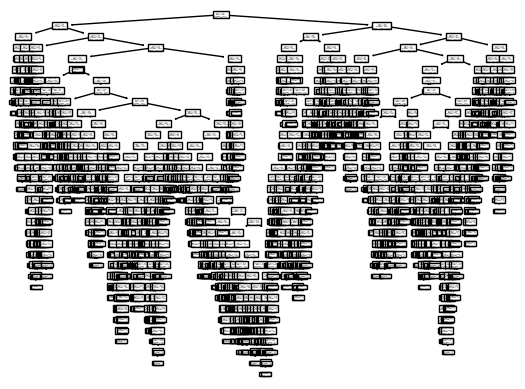

In [321]:
tree.plot_tree(myTree)